In [1]:
# %%
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

In [2]:

def compute_action(theta, beta):
    """
    Compute the action S(theta) for U(1) gauge theory in 1-D.

    Parameters:
    - theta: array of angles (radians) at each lattice site.
    - beta: coupling constant.

    Returns:
    - action: scalar value of the action.
    """
    # Compute differences between neighboring sites with periodic boundary conditions
    delta_theta = theta - np.roll(theta, -1)
    # Action: -beta * sum cos(delta_theta)
    action = -beta * np.sum(np.cos(delta_theta))
    return action

def compute_gradient(theta, beta):
    """
    Compute the gradient of the action with respect to theta.

    Parameters:
    - theta: array of angles (radians) at each lattice site.
    - beta: coupling constant.

    Returns:
    - grad: array of gradients at each lattice site.
    """
    # Compute differences with neighbors
    delta_theta_forward = theta - np.roll(theta, -1)
    delta_theta_backward = theta - np.roll(theta, 1)
    # Gradient: beta * [sin(theta - theta_next) + sin(theta - theta_prev)]
    grad = beta * (np.sin(delta_theta_forward) + np.sin(delta_theta_backward))
    return grad

def leapfrog(theta, p, grad, epsilon, N_steps, beta):
    """
    Perform leapfrog integration.

    Parameters:
    - theta: initial angles.
    - p: initial momenta.
    - grad: gradient of the action at initial theta.
    - epsilon: step size.
    - N_steps: number of leapfrog steps.
    - beta: coupling constant.

    Returns:
    - theta_new: updated angles after leapfrog.
    - p_new: updated momenta after leapfrog.
    """
    theta_new = np.copy(theta)
    p_new = np.copy(p)
    
    # Half step for momenta
    p_new -= 0.5 * epsilon * compute_gradient(theta_new, beta)
    
    # Alternate full steps
    for _ in range(N_steps):
        # Full step for theta
        theta_new += epsilon * p_new
        # Keep theta within [0, 2pi)
        theta_new = np.mod(theta_new, 2*np.pi)
        
        # Compute gradient at new theta
        grad = compute_gradient(theta_new, beta)
        
        # Full step for momentum, except at the end of trajectory
        if _ != N_steps - 1:
            p_new -= epsilon * grad
    
    # Half step for momenta at the end
    p_new -= 0.5 * epsilon * compute_gradient(theta_new, beta)
    
    return theta_new, p_new

def hmc_step(theta_current, beta, epsilon, N_steps):
    """
    Perform a single HMC step.

    Parameters:
    - theta_current: current angles.
    - beta: coupling constant.
    - epsilon: step size.
    - N_steps: number of leapfrog steps.

    Returns:
    - theta_new: new angles after HMC step.
    - accept: boolean indicating whether the new configuration was accepted.
    """
    # Sample momenta from Gaussian distribution
    p_current = np.random.normal(0, 1, size=theta_current.shape)
    
    # Compute current Hamiltonian
    current_action = compute_action(theta_current, beta)
    current_kinetic = 0.5 * np.sum(p_current**2)
    current_H = current_action + current_kinetic
    
    # Perform leapfrog integration
    theta_proposed, p_proposed = leapfrog(theta_current, p_current, compute_gradient(theta_current, beta), epsilon, N_steps, beta)
    
    # Compute proposed Hamiltonian
    proposed_action = compute_action(theta_proposed, beta)
    proposed_kinetic = 0.5 * np.sum(p_proposed**2)
    proposed_H = proposed_action + proposed_kinetic
    
    # Metropolis acceptance step
    delta_H = proposed_H - current_H
    if np.random.rand() < np.exp(-delta_H):
        accept = True
        theta_new = theta_proposed
    else:
        accept = False
        theta_new = theta_current
    
    return theta_new, accept

def autocorrelation(x, max_lag):
    """
    Compute autocorrelation for a 1-D array x up to max_lag.

    Parameters:
    - x: input data array.
    - max_lag: maximum lag to compute autocorrelation.

    Returns:
    - acf: autocorrelation values from lag 0 to max_lag.
    """
    n = len(x)
    x_mean = np.mean(x)
    x_var = np.var(x)
    acf = np.array([np.corrcoef(x[:n - lag], x[lag:])[0,1] if lag !=0 else 1.0 for lag in range(max_lag +1)])
    return acf



Starting HMC simulation...
Step 1000/6000
Step 2000/6000
Step 3000/6000
Step 4000/6000
Step 5000/6000
Step 6000/6000
Acceptance rate: 98.25%


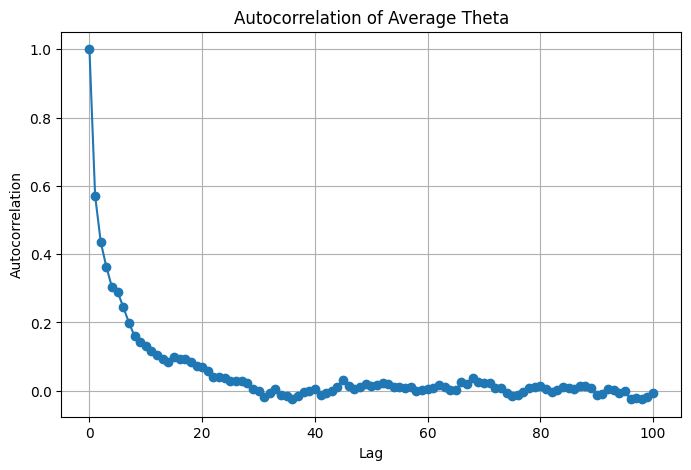

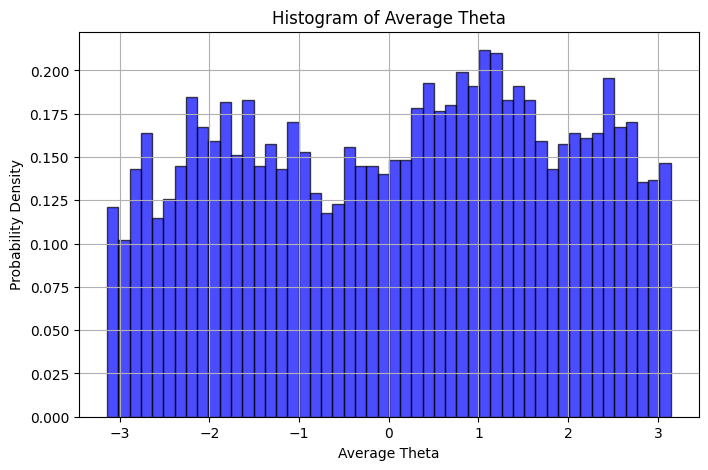

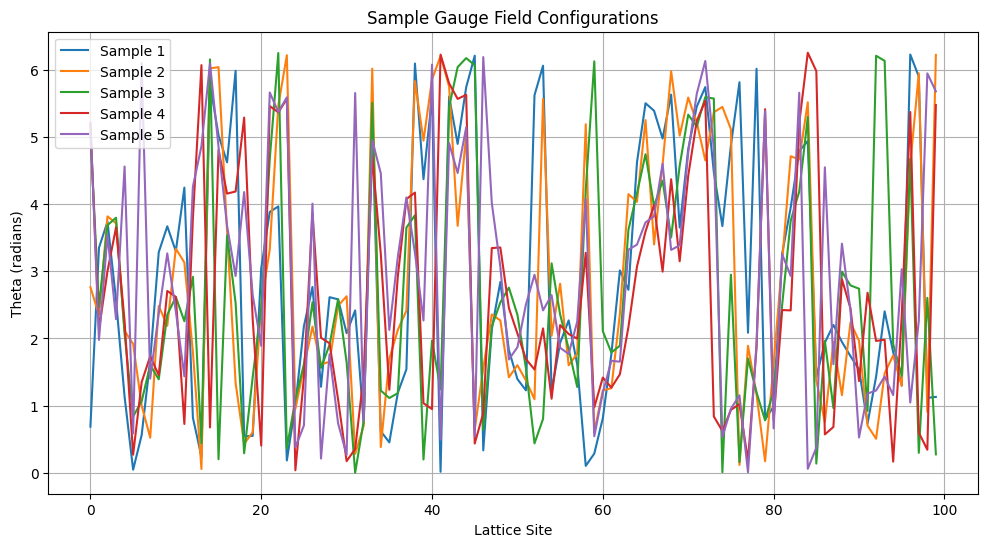

In [3]:
def main():
    # Simulation parameters
    L = 100                # Number of lattice sites
    beta = 1.0             # Coupling constant
    epsilon = 0.1          # Leapfrog step size
    N_steps = 10           # Number of leapfrog steps per HMC step
    N_samples = 5000       # Total number of HMC samples
    N_thermal = 1000       # Number of thermalization steps
    max_lag = 100          # Maximum lag for autocorrelation

    # Initialize theta randomly in [0, 2pi)
    theta = np.random.uniform(0, 2*np.pi, L)
    
    # Lists to store samples and acceptance rate
    samples = []
    accept_count = 0

    print("Starting HMC simulation...")
    
    for step in range(1, N_samples + N_thermal +1):
        theta, accepted = hmc_step(theta, beta, epsilon, N_steps)
        if accepted:
            accept_count +=1
        
        # After thermalization, store samples
        if step > N_thermal:
            samples.append(np.copy(theta))
        
        # Print progress
        if step % 1000 ==0:
            print(f"Step {step}/{N_samples + N_thermal}")
    
    acceptance_rate = accept_count / (N_samples + N_thermal)
    print(f"Acceptance rate: {acceptance_rate*100:.2f}%")
    
    samples = np.array(samples)  # Shape: (N_samples, L)
    
    # Compute observable: average cosine and sine of theta
    avg_cos = np.mean(np.cos(samples), axis=1)
    avg_sin = np.mean(np.sin(samples), axis=1)
    avg_theta = np.arctan2(avg_sin, avg_cos)
    
    # Compute autocorrelation of the observable
    acf = autocorrelation(avg_theta, max_lag)
    
    # Plot autocorrelation
    plt.figure(figsize=(8,5))
    plt.plot(acf, marker='o')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation of Average Theta')
    plt.grid(True)
    plt.show()
    
    # Plot histogram of the observable
    plt.figure(figsize=(8,5))
    plt.hist(avg_theta, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Average Theta')
    plt.ylabel('Probability Density')
    plt.title('Histogram of Average Theta')
    plt.grid(True)
    plt.show()
    
    # Plot some sample configurations
    plt.figure(figsize=(12,6))
    for i in range(5):
        plt.plot(samples[i], label=f'Sample {i+1}')
    plt.xlabel('Lattice Site')
    plt.ylabel('Theta (radians)')
    plt.title('Sample Gauge Field Configurations')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
